In [1]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Clean the input directory structure.
! rm -rf cmp23 icdar preprocessed features
! mkdir -p {cmp23,icdar}/{fe,}male

# Self explanatory.
! cp ../input/cmp23-handwritten-males-vs-females/Males/Males/* cmp23/male
! cp ../input/cmp23-handwritten-males-vs-females/Females/Females/* cmp23/female

# Copy the zip files and the train answers.
! cp ../input/icdar2013-gender-prediction-from-handwriting/{[0-9]*_[0-9]*.zip,train_answers.csv} icdar
# Unzip in the working directory.
! for z in $(ls icdar/*.zip); do unzip $z -d icdar >/dev/null; done
# Couldn't break this line into many. The notebook treats each line as a bash shell of its own.
! cd icdar; tail +2 train_answers.csv | while read -d, id && read gender; do id=$(printf "%04d" $id); [[ ${gender:0:1} = 1 ]] && gender=male || gender=female; mv "$id"_{3,4}.jpg $gender; done
# Delete unwanted files.
! rm icdar/{*.zip,*.jpg,train_answers.csv}
# Rename all the dataset files to simple names.
! function rename { for path in "$@"; do cd $path; c=1; for file in $(ls); do mv $file $c.jpg; let c=c+1; done; cd - >/dev/null; done; }; rename {cmp23,icdar}/{fe,}male

# Check the directory tree.
! tree --filelimit 100

.
├── __notebook__.ipynb
├── cmp23
│   ├── female [131 entries exceeds filelimit, not opening dir]
│   └── male [232 entries exceeds filelimit, not opening dir]
└── icdar
    ├── female [286 entries exceeds filelimit, not opening dir]
    └── male [278 entries exceeds filelimit, not opening dir]

6 directories, 1 file
CPU times: user 1.28 s, sys: 262 ms, total: 1.54 s
Wall time: 1min 20s


In [2]:
# Imports.
import os
import glob
import cv2
import functools
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure
from skimage.feature import graycomatrix, graycoprops

In [3]:
# Helper functions.
def cmp(gender: str, id: int):
    return 'cmp23/' + gender + '/' + str(id) + '.jpg'

def icd(gender: str, id: int):
    return 'icdar/' + gender + '/' + str(id) + '.jpg'

In [4]:
# Constants.
CMP_IMAGES = glob.glob(cmp('*', '*'))
ICD_IMAGES = glob.glob(icd('*', '*'))
ALL_IMAGES = CMP_IMAGES + ICD_IMAGES

TST_IMAGES = [
    cmp('female', 9),
    icd('male', 67),
    cmp('male', 89),
    icd('female', 3),
    icd('male', 12),
    cmp('female', 4),
] # Some images' paths used oberservation.

PREPROCESSING_GAUSSIAN_BLUR_KERNEL_SIZE = (9, 9)
PREPROCESSING_DILATION_ITERATIONS = 8
PREPROCESSING_DILATION_SIZE = (15, 20) # We need more dilation into the vertical axis.
PREPROCESSING_THRESH_BLOCK_SIZE = 101 # 101 is quick enough, yet robust.
PREPROCESSING_THRESH_C = 30 # Note that we need a big C subtractor when we use a big block size.
X_CUT_PERCENT = 0.1 # Don't cut too much since some people write to edge of the paper.
Y_CUT_PERCENT = 0.5 # 0.5% on both sides is enough.

In [5]:
# More helper functions.
def pre(version: str):
    return lambda image_path: f'preprocessed/{version}/{image_path}'

def feat(feature: str):
    return lambda image_path: f'features/{feature}/{image_path}'

def preview(images: list):
    fig = plt.figure(figsize=(20, 20))
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        fig.add_subplot(4, 4, i + 1)
        plt.imshow(image, cmap='gray')
    plt.show()

In [6]:
# Remove corrupt images from our image lists, like F87.jpg.
for image_path in ALL_IMAGES:
    if cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) is None:
        CMP_IMAGES.remove(image_path)
        ICD_IMAGES.remove(image_path)
        ALL_IMAGES.remove(image_path)
        TST_IMAGES.remove(image_path)

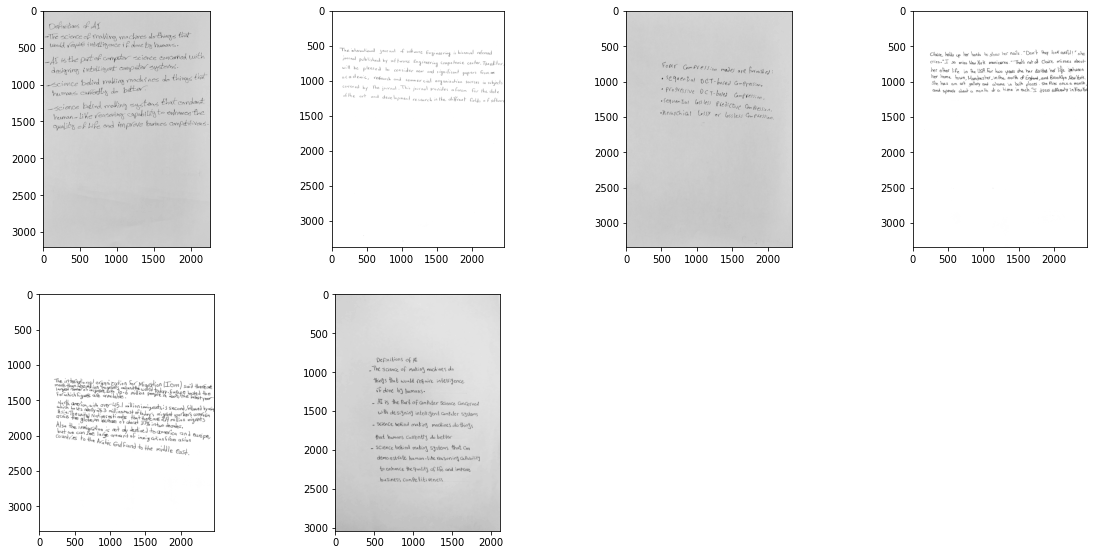

In [7]:
# Preview the test images before preprocessing them.
preview(TST_IMAGES)

In [8]:
# Make a directory for the preprocessed versions of the datatset.
! mkdir -p preprocessed/{bw,gray}/{cmp23,icdar}/{fe,}male

In [9]:
%%time
# Preprocess the images and write them to the disk.
for image_path in ALL_IMAGES:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Cut some percentage of the images' edges. They are usually noisy.
    height, width = image.shape
    if X_CUT_PERCENT:
        start_x, end_x = int(width / (100/X_CUT_PERCENT)), width - int(width / (100/X_CUT_PERCENT))
        image = image[:, start_x:end_x]
    if Y_CUT_PERCENT:
        start_y, end_y = int(height / (100/Y_CUT_PERCENT)), height - int(height / (100/Y_CUT_PERCENT))
        image = image[start_y:end_y, :]
    # Blur the image to decrease sharpness. Good for thresholding.
    img = cv2.GaussianBlur(image, PREPROCESSING_GAUSSIAN_BLUR_KERNEL_SIZE, 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                                PREPROCESSING_THRESH_BLOCK_SIZE, PREPROCESSING_THRESH_C)
    # Dilate the image to create a contour out of the handwritten text.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, PREPROCESSING_DILATION_SIZE)
    img = cv2.dilate(img, kernel, iterations=PREPROCESSING_DILATION_ITERATIONS)
    contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    # Get the biggest contour that contains the text.
    biggest_contour = functools.reduce(lambda c1, c2: c1 if cv2.contourArea(c1) > cv2.contourArea(c2) else c2,
                                       contours)
    # Get the original image in black and white. Note that this version is not blured.
    bw = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                               PREPROCESSING_THRESH_BLOCK_SIZE, PREPROCESSING_THRESH_C)
    bw = cv2.threshold(bw, 255 / 2, 255, cv2.THRESH_BINARY)[1]
    # Crop only the text part.
    x, y, w, h = cv2.boundingRect(biggest_contour)
    image = image[y:y + h, x:x + w] # This is a gray version
    bw = bw[y:y + h, x:x + w] # This is a BW version
    # Write the preprocessed images to the disk.
    cv2.imwrite(pre('gray')(image_path), image)
    cv2.imwrite(pre('bw')(image_path), bw)

CPU times: user 11min 38s, sys: 14.4 s, total: 11min 52s
Wall time: 11min 15s


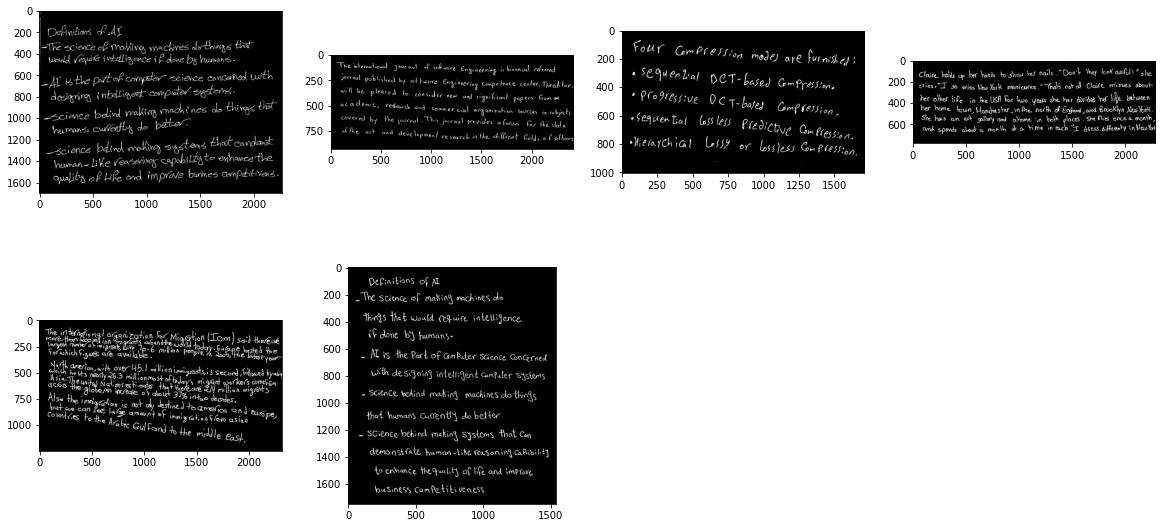

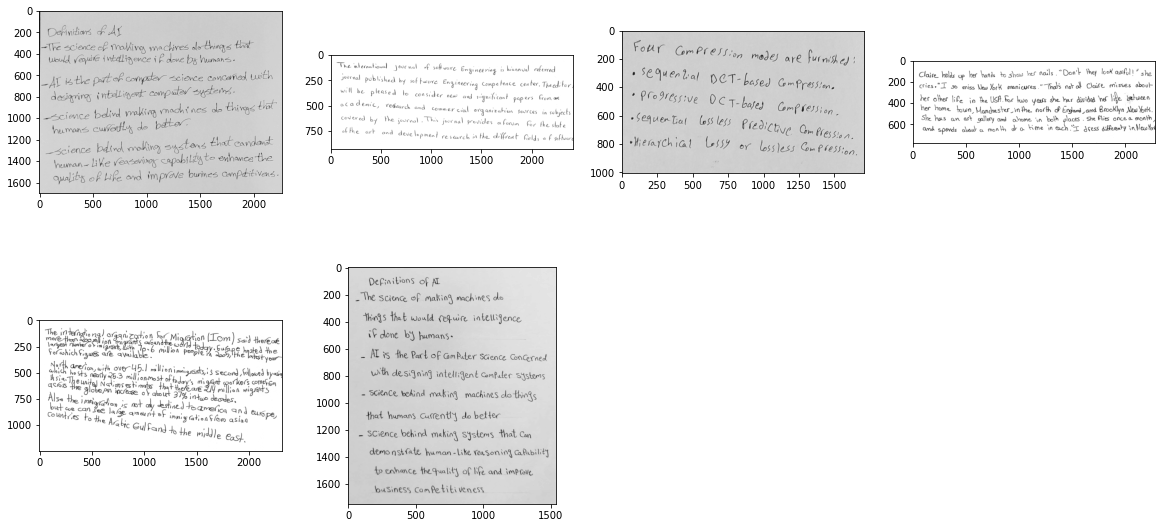

In [10]:
# Preview the test images after preprocessing.
bw_test_images = map(pre('bw'), TST_IMAGES)
gray_test_images = map(pre('gray'), TST_IMAGES)

preview(bw_test_images)
preview(gray_test_images)

In [11]:
# Make a directory for each and every feature we have.
! mkdir -p features/{lbp,glcm,gabor,ar_coeff,hog,chain_codes,chain_code_pairs,segment_slopes,dist_curv,cold,hinge}/{icdar,cmp23}/{fe,}male

In [12]:
%%time
# GLCM features.
angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
distances = [1]
props = ['contrast', 'homogeneity', 'energy', 'correlation']

for image_path in ALL_IMAGES:
    prep_image_path = pre('bw')(image_path)
    image = cv2.imread(prep_image_path, cv2.IMREAD_GRAYSCALE)
    image = np.where(image > 255 / 2, 1, 0)
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=2, symmetric=False, normed=True)
    features = []
    for prop in props:
        features.append(graycoprops(glcm, prop).ravel())
    features.append([-np.sum(glcm[:, :, d, a] * np.log(glcm[:, :, d, a]))
                     for d in range(len(distances)) for a in range(len(angles))])
    features = np.hstack(features)
    np.savetxt(feat('glcm')(image_path), features)

CPU times: user 52.5 s, sys: 539 ms, total: 53 s
Wall time: 53 s


0 1


0 2


0 3


0 4


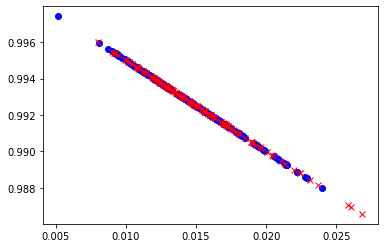

0 5


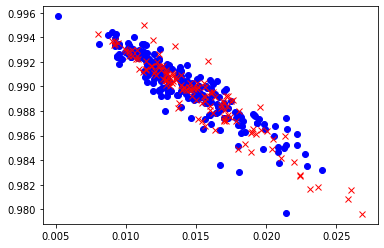

0 6


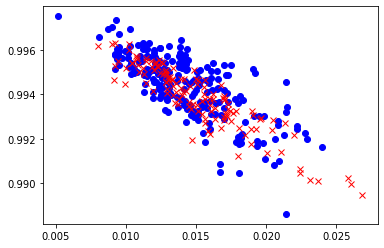

0 7


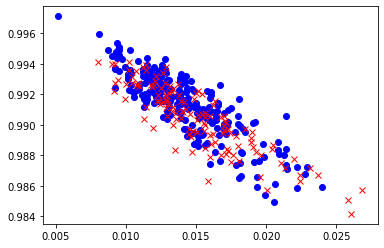

0 8


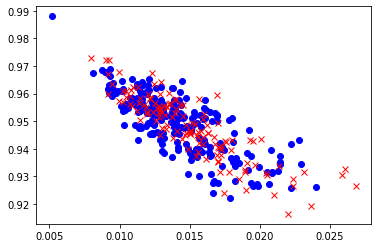

0 9


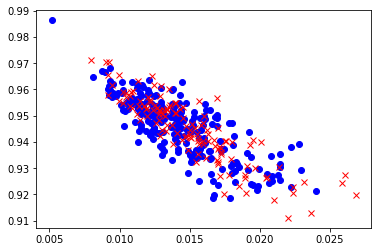

0 10


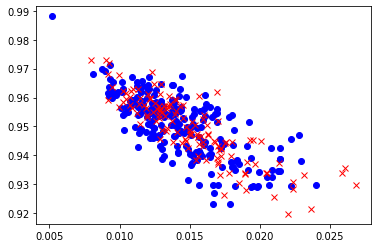

0 11


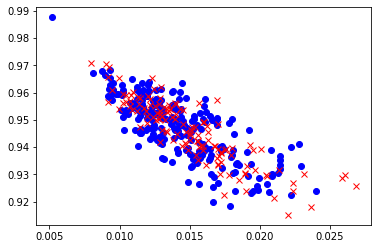

0 12


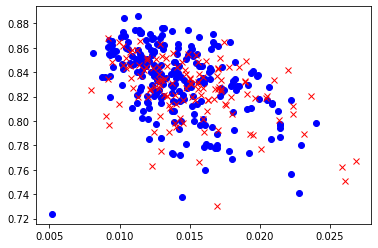

0 13


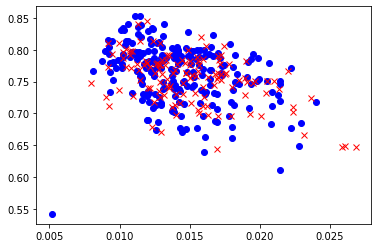

0 14


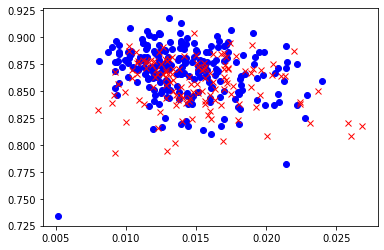

0 15


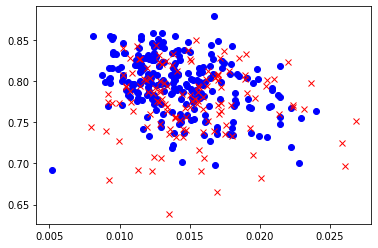

0 16


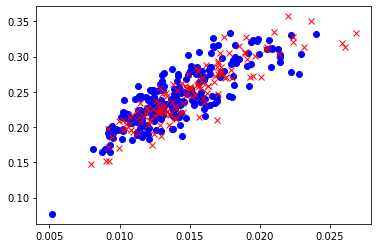

0 17


0 18


0 19


1 0


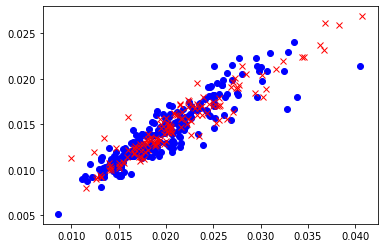

1 2


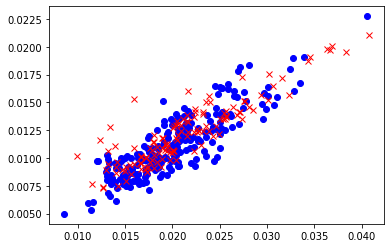

1 3


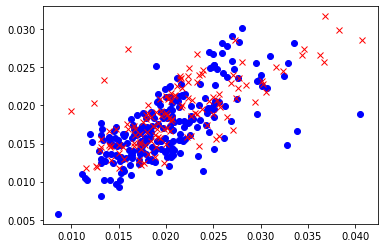

1 4


1 5


1 6


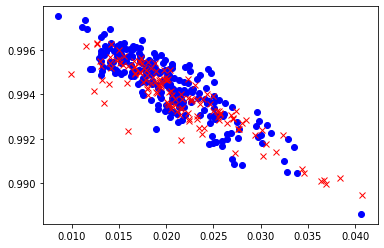

1 7


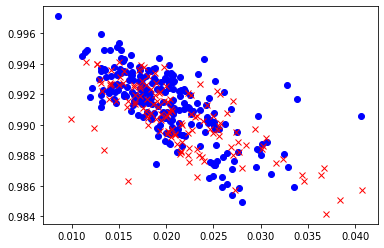

1 8


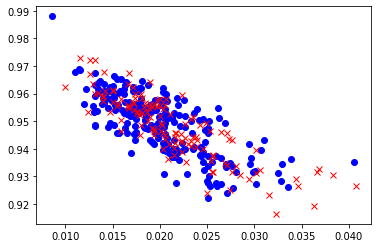

1 9


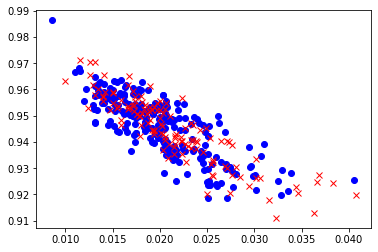

1 10


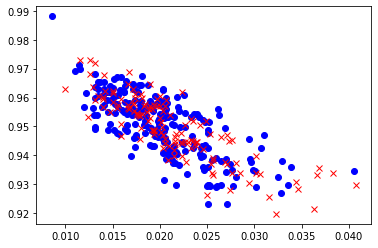

1 11


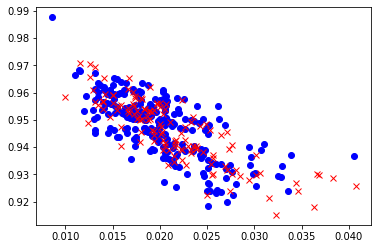

1 12


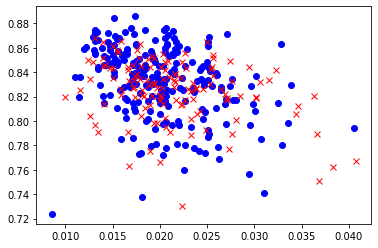

1 13


1 14


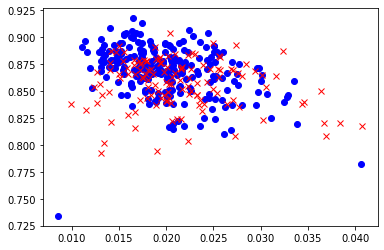

1 15


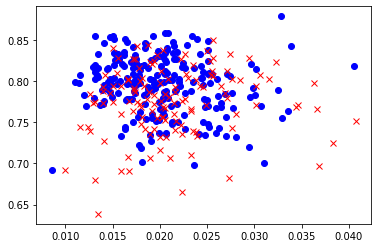

1 16


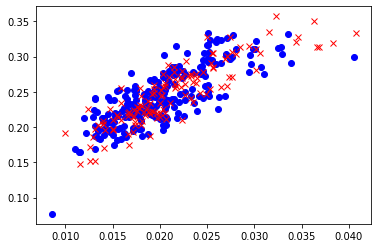

1 17


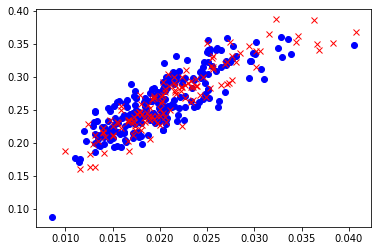

1 18


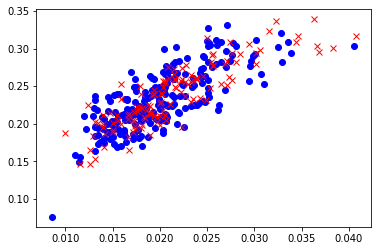

1 19


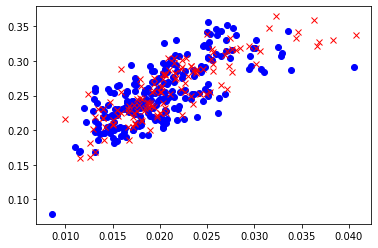

2 0


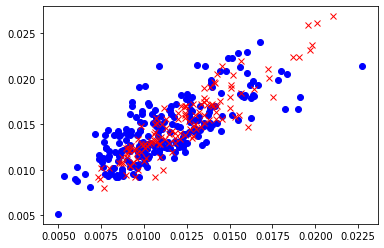

2 1


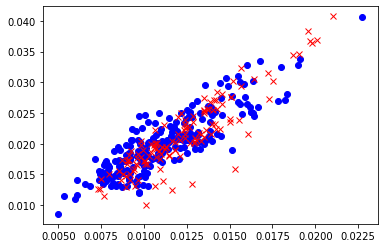

2 3


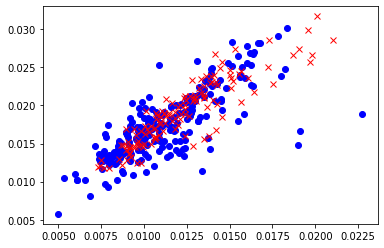

2 4


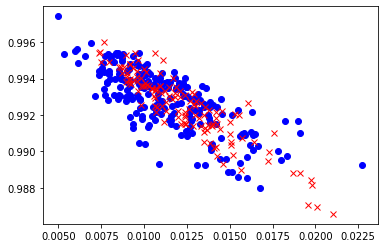

2 5


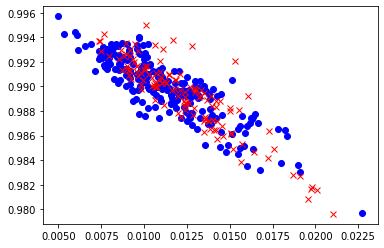

2 6


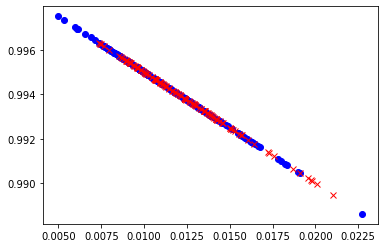

2 7


2 8


2 9


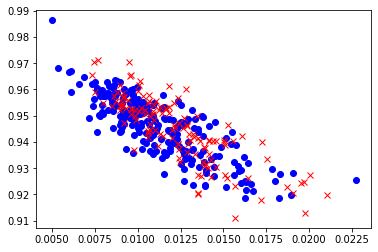

2 10


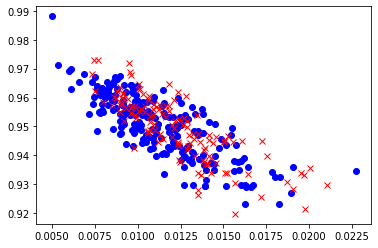

2 11


2 12


2 13


2 14


2 15


2 16


2 17


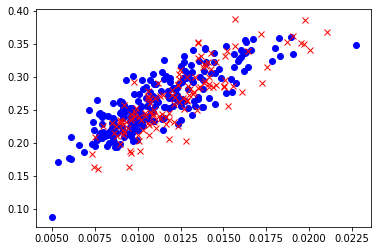

2 18


2 19


3 0


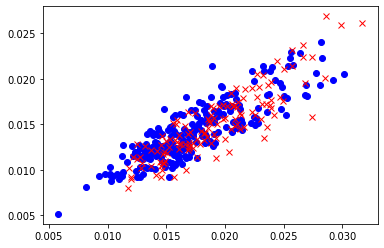

3 1


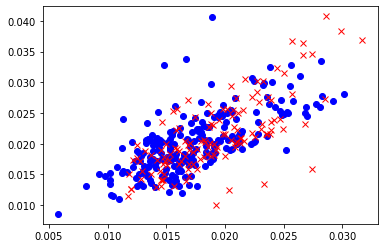

3 2


3 4


3 5


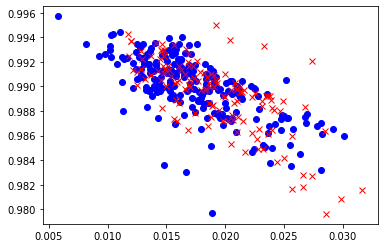

3 6


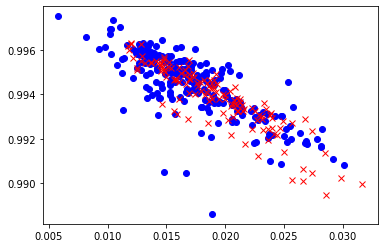

3 7


3 8


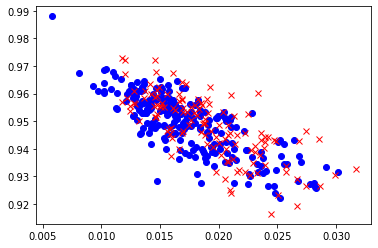

3 9


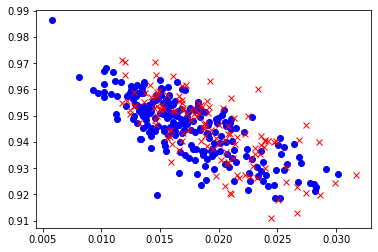

3 10


3 11


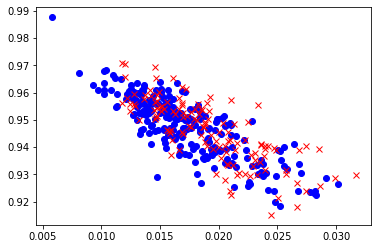

3 12


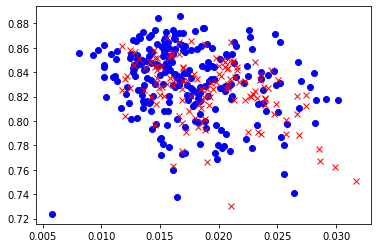

3 13


3 14


3 15


3 16


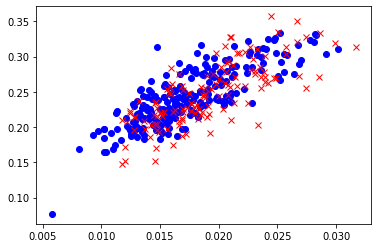

3 17


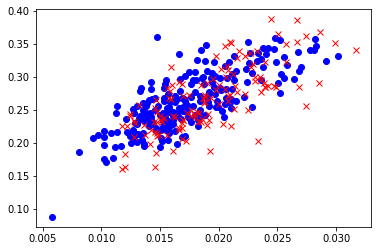

3 18


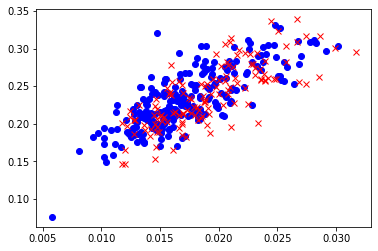

3 19


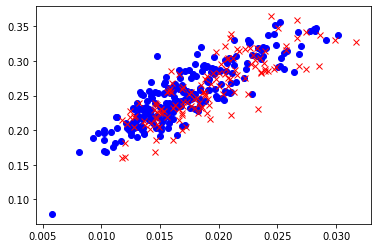

4 0


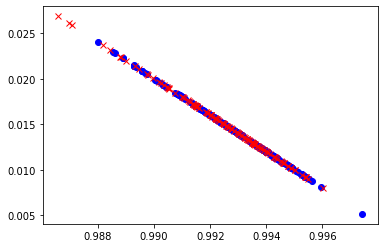

4 1


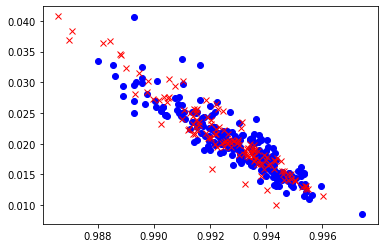

4 2


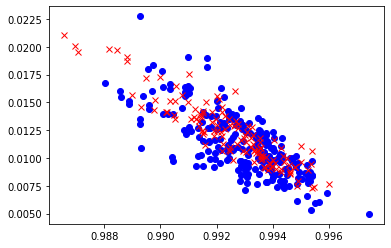

4 3


4 5


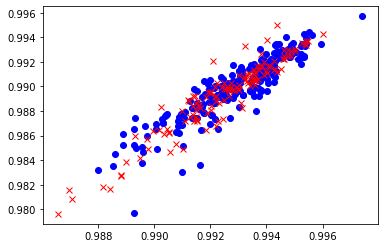

4 6


4 7


4 8


4 9


4 10


4 11


4 12


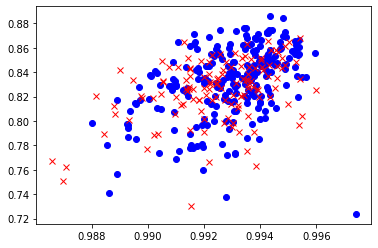

4 13


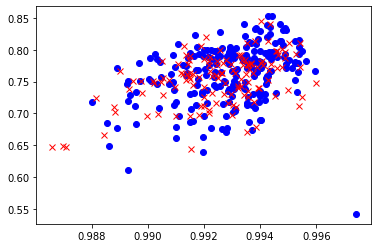

4 14


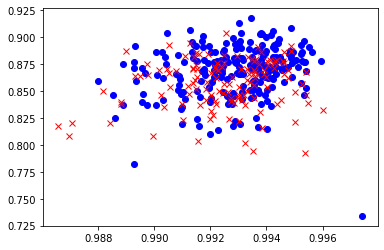

4 15


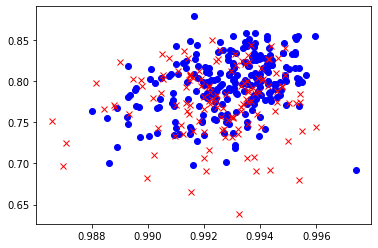

4 16


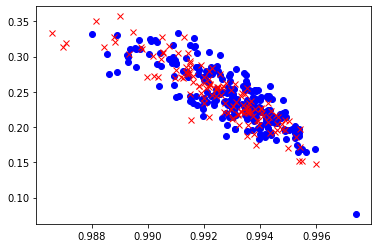

4 17


4 18


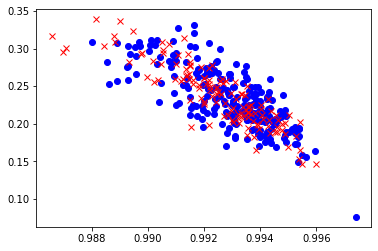

4 19


5 0


5 1


5 2


5 3


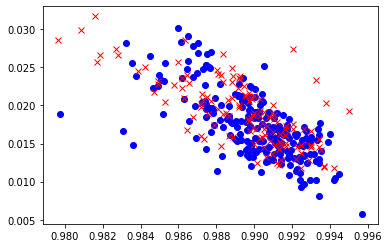

5 4


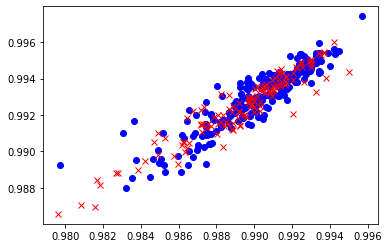

5 6


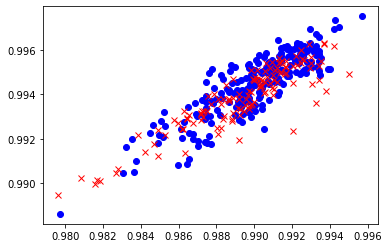

5 7


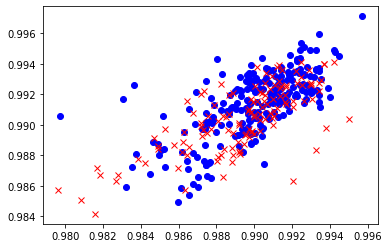

5 8


5 9


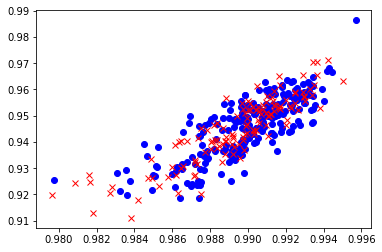

5 10


5 11


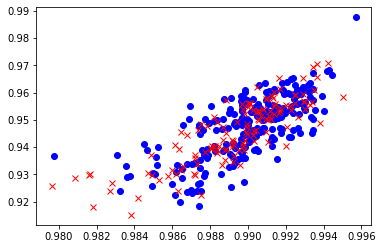

5 12


5 13


5 14


5 15


5 16


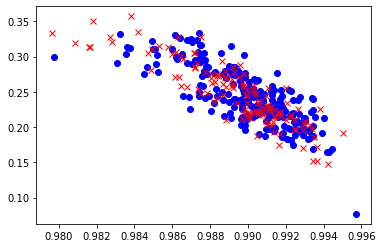

5 17


5 18


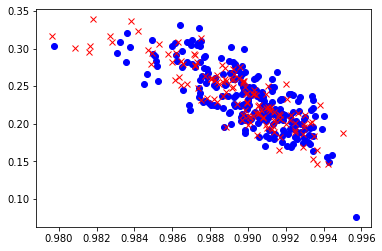

5 19


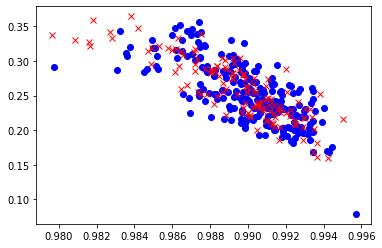

6 0


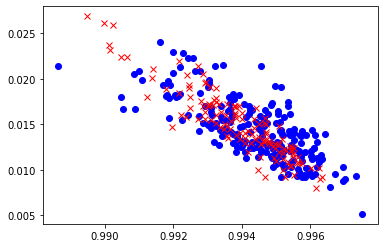

6 1


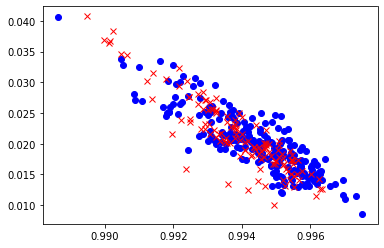

6 2


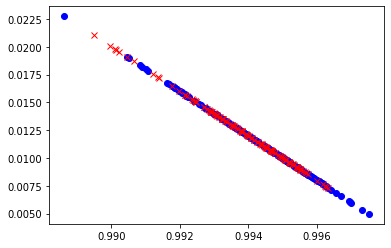

6 3


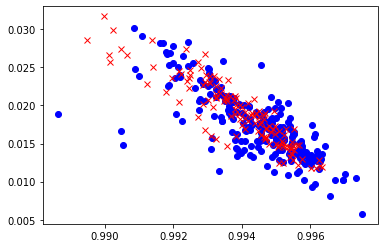

6 4


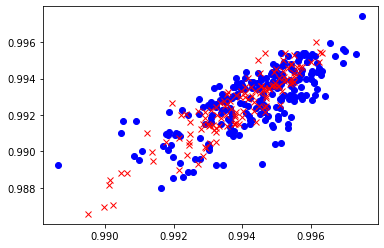

6 5


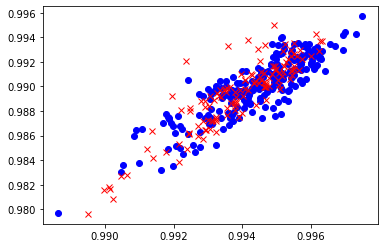

6 7


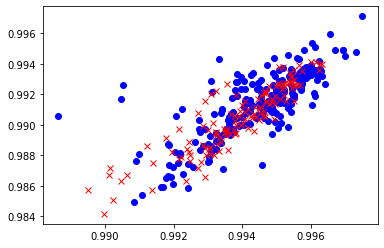

6 8


6 9


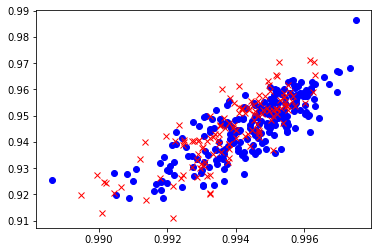

6 10


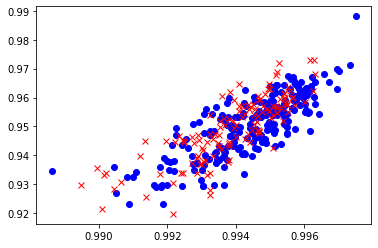

6 11


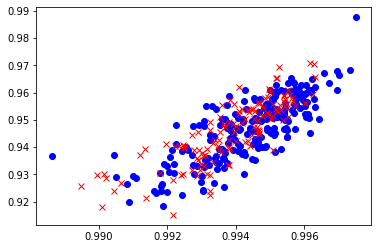

6 12


6 13


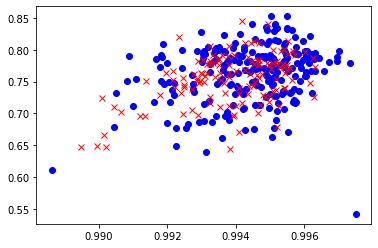

6 14


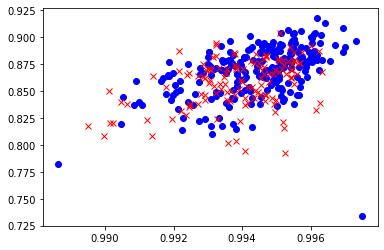

6 15


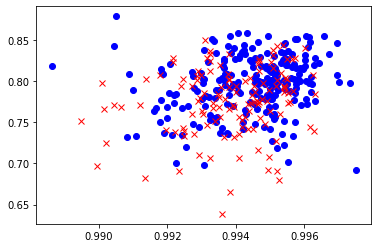

6 16


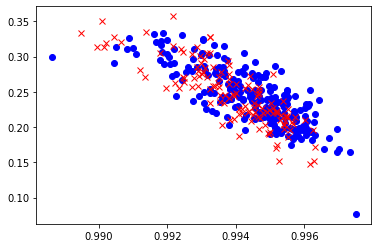

6 17


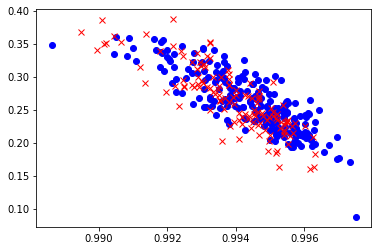

6 18


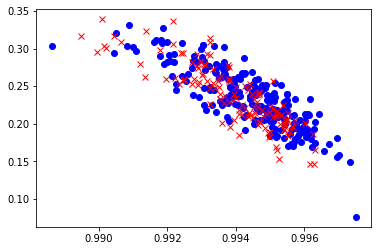

6 19


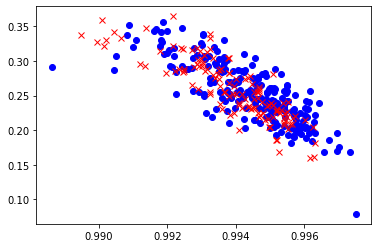

7 0


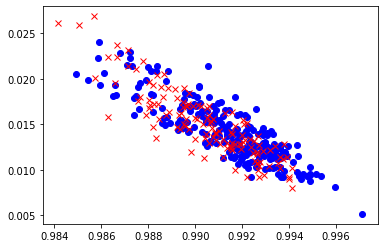

7 1


7 2


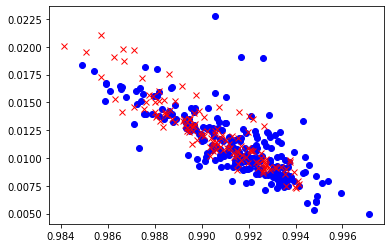

7 3


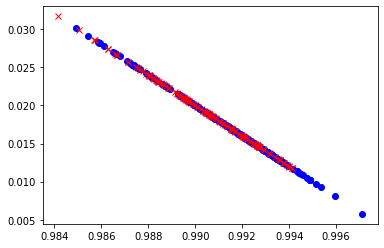

7 4


7 5


7 6


7 8


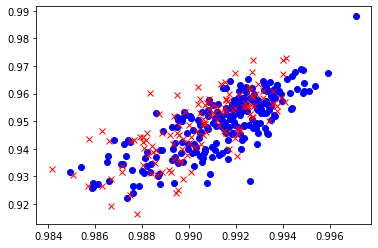

7 9


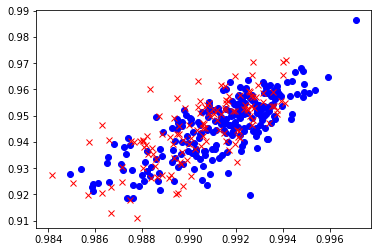

7 10


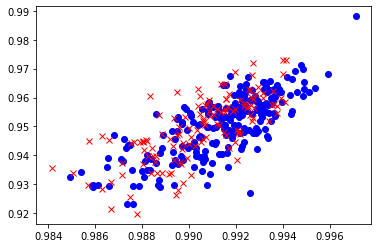

7 11


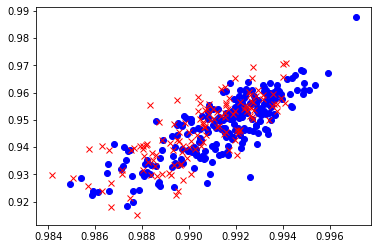

7 12


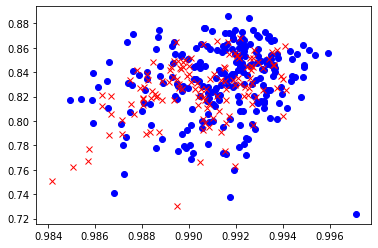

7 13


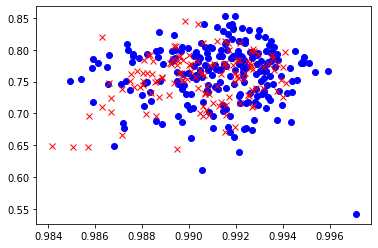

7 14


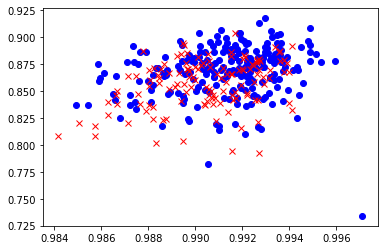

7 15


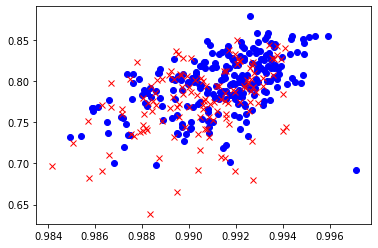

7 16


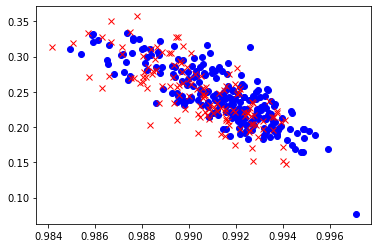

7 17


7 18


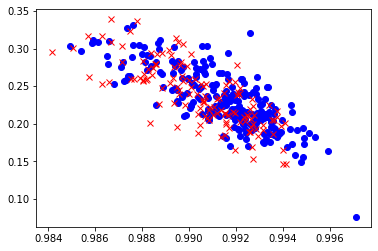

7 19


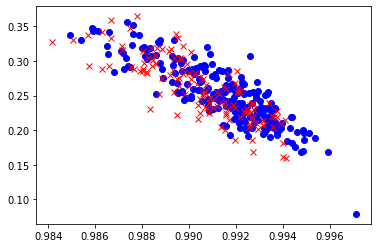

8 0


8 1


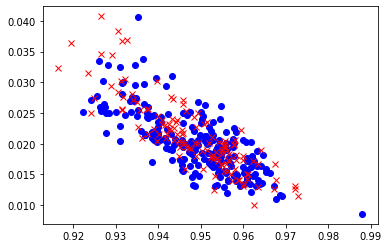

8 2


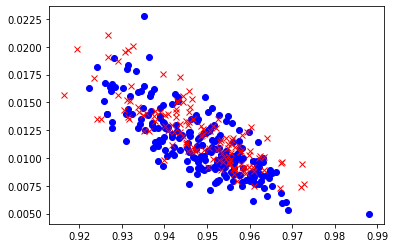

8 3


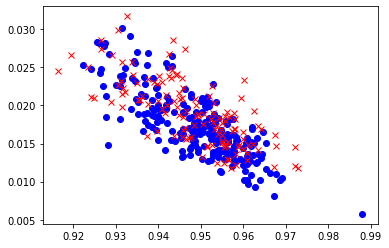

8 4


8 5


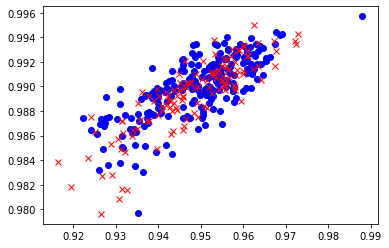

8 6


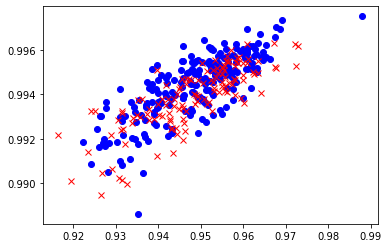

8 7


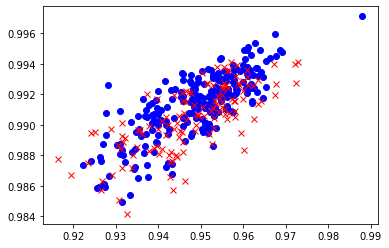

8 9


8 10


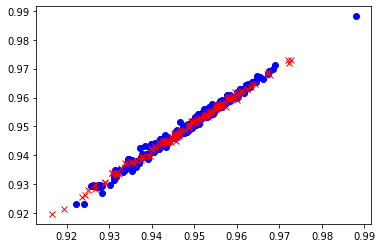

8 11


8 12


8 13


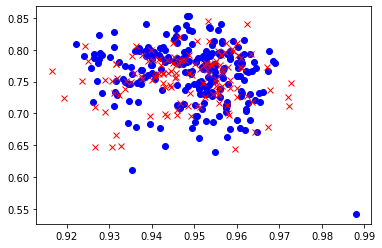

8 14


8 15


8 16


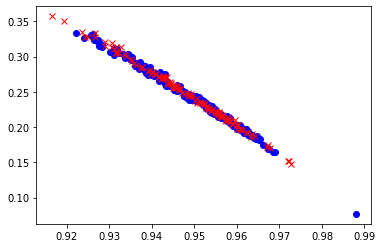

8 17


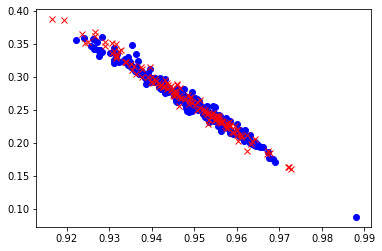

8 18


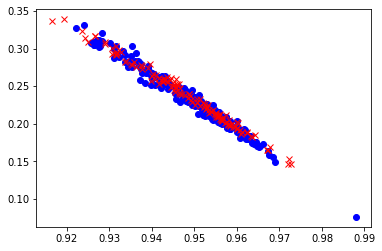

8 19


9 0


9 1


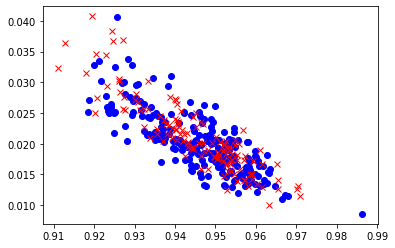

9 2


9 3


9 4


9 5


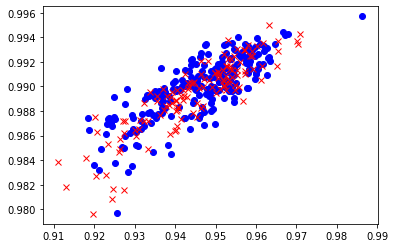

9 6


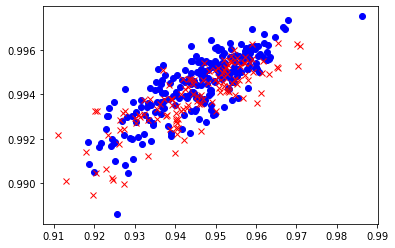

9 7


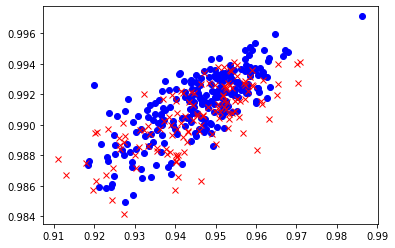

9 8


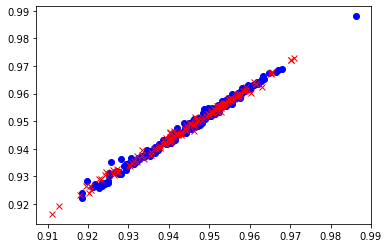

9 10


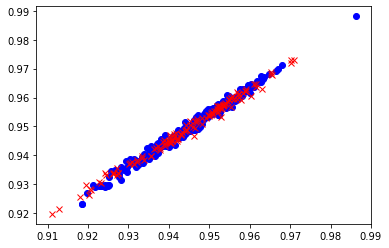

9 11


9 12


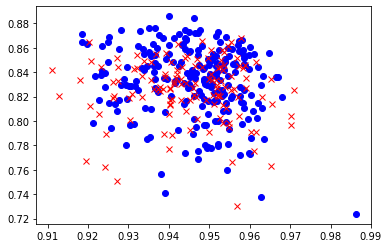

9 13


9 14


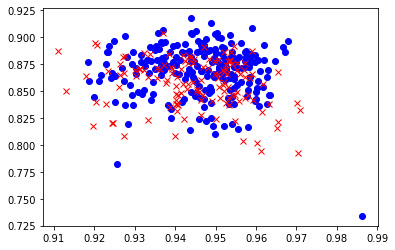

9 15


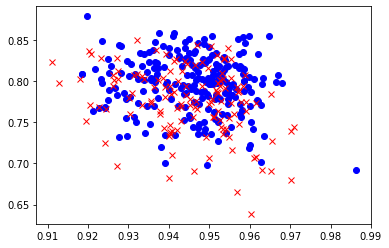

9 16


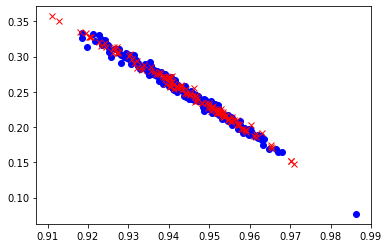

9 17


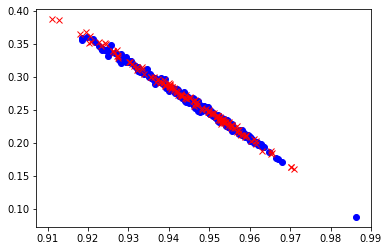

9 18


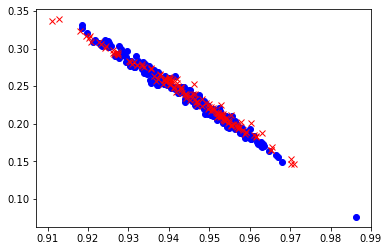

9 19


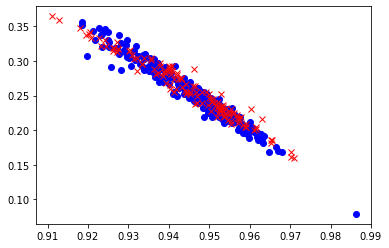

10 0


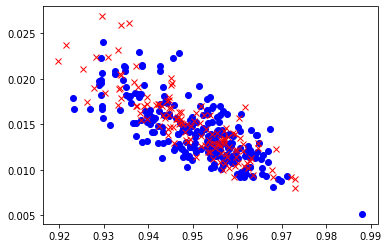

10 1


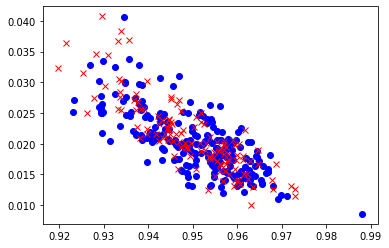

10 2


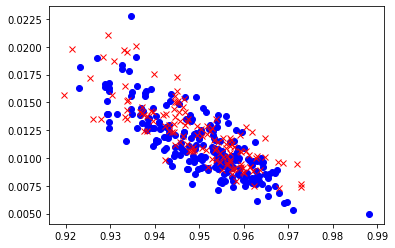

10 3


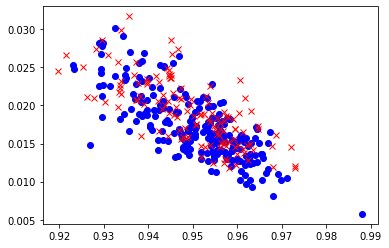

10 4


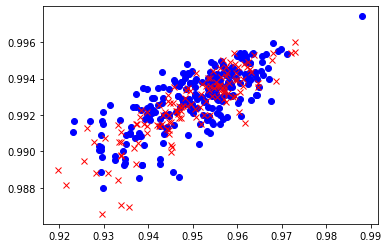

10 5


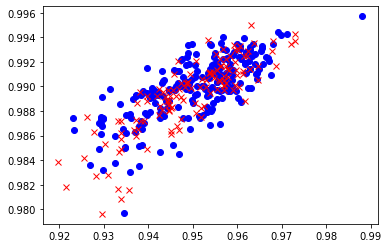

10 6


10 7


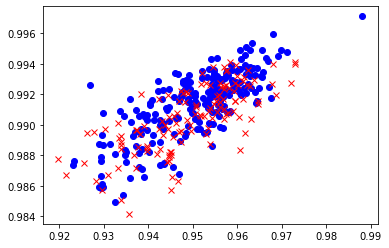

10 8


10 9


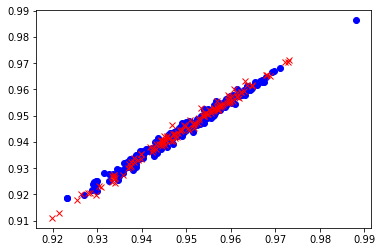

10 11


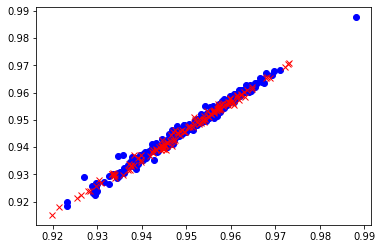

10 12


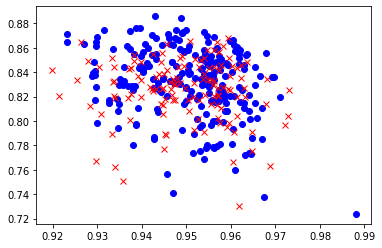

10 13


10 14


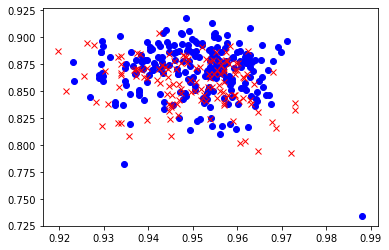

10 15


10 16


10 17


10 18


10 19


11 0


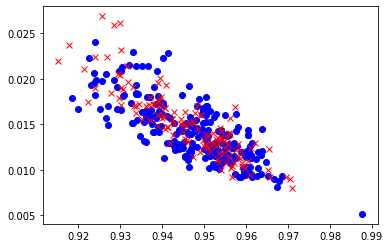

11 1


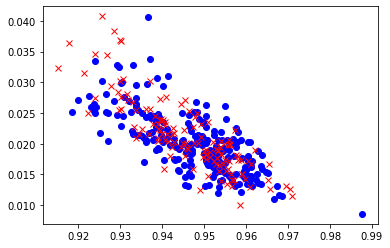

11 2


11 3


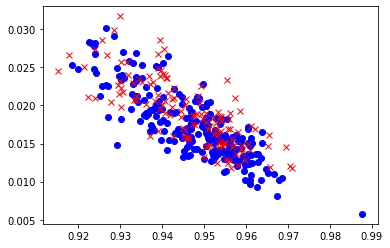

11 4


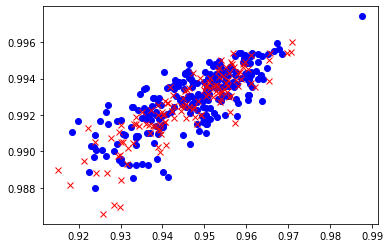

11 5


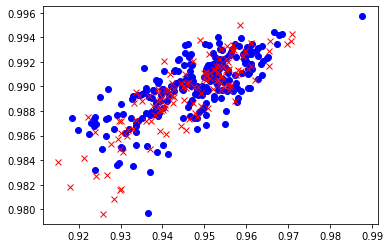

11 6


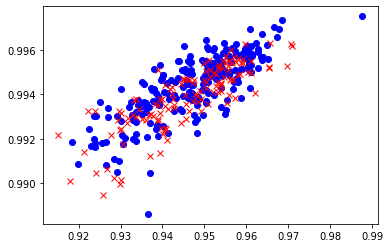

11 7


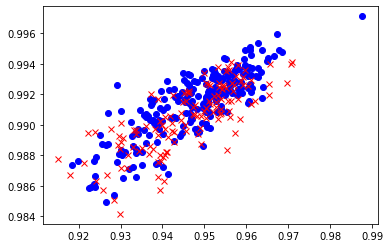

11 8


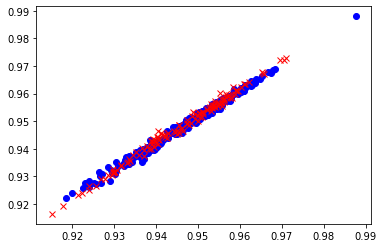

11 9


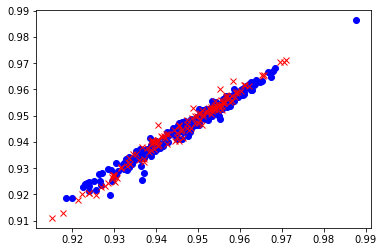

11 10


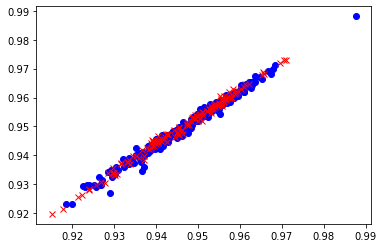

11 12


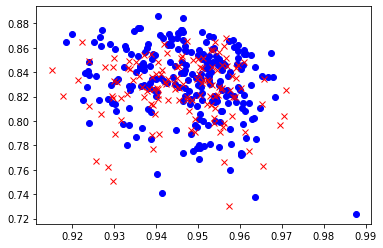

11 13


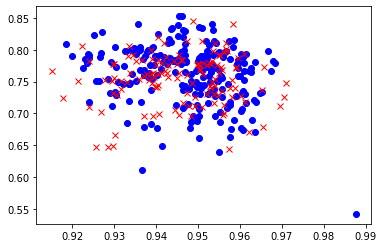

11 14


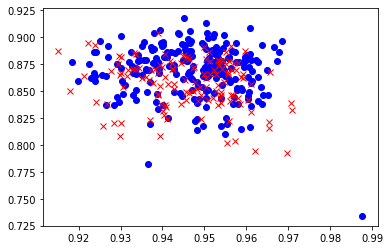

11 15


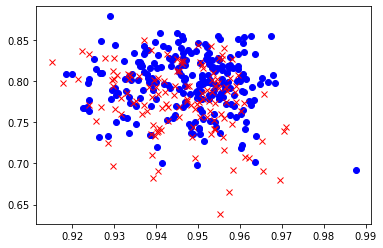

11 16


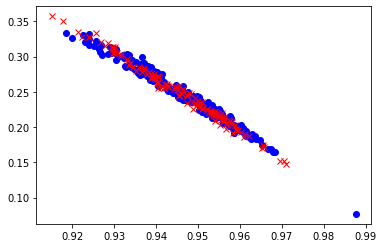

11 17


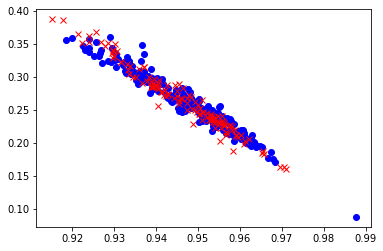

11 18


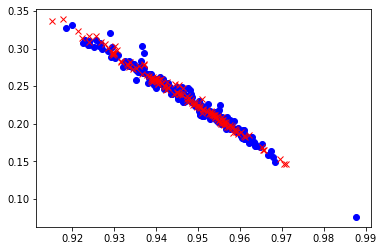

11 19


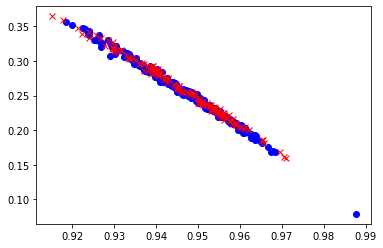

12 0


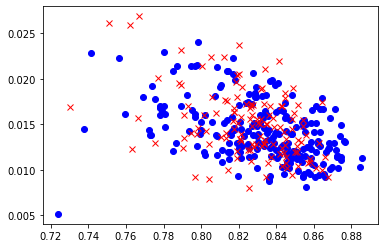

12 1


12 2


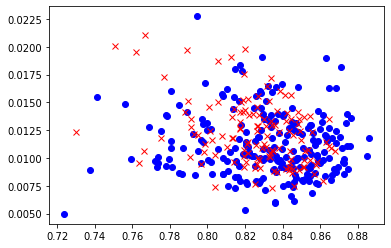

12 3


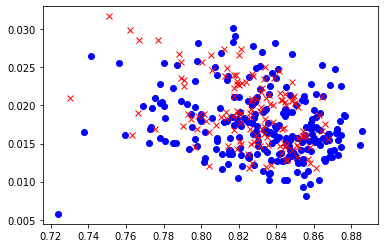

12 4


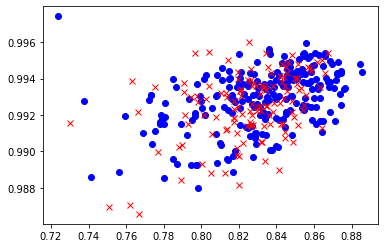

12 5


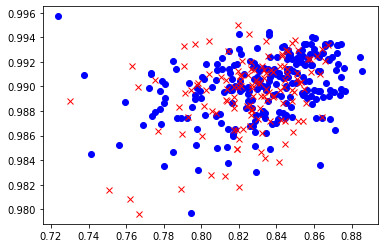

12 6


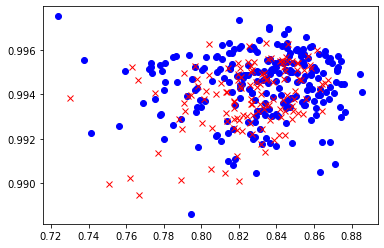

12 7


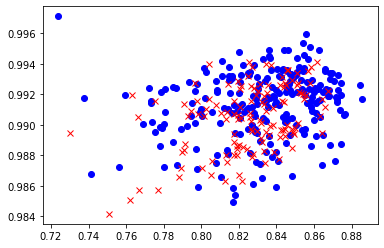

12 8


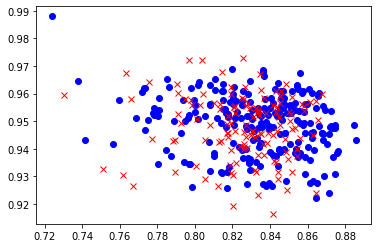

12 9


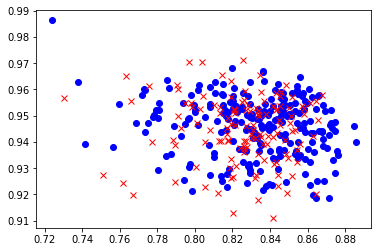

12 10


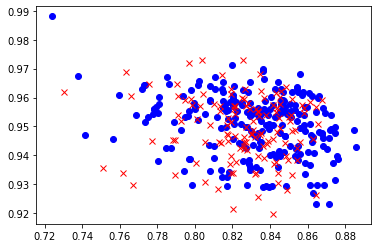

12 11


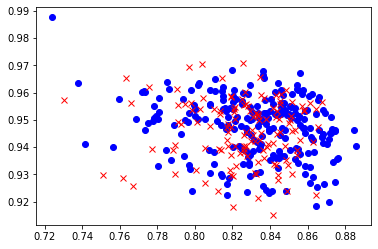

12 13


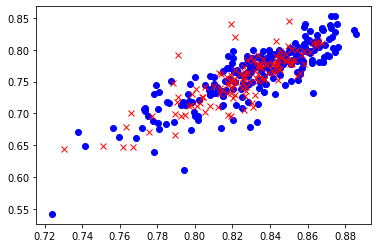

12 14


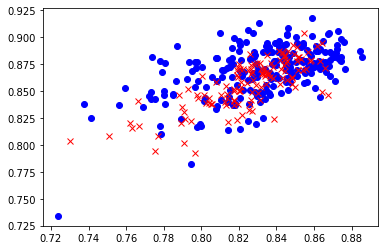

12 15


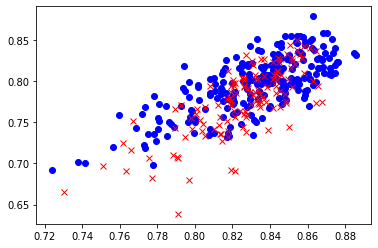

12 16


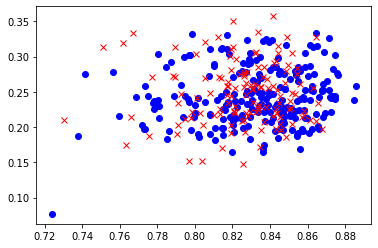

12 17


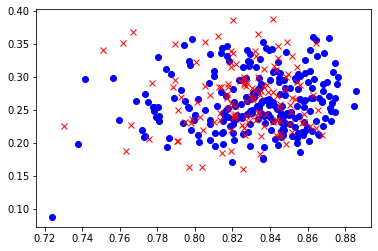

12 18


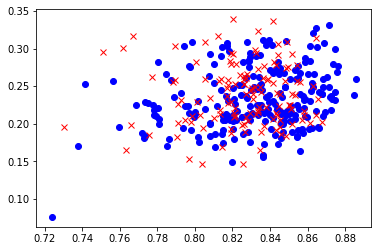

12 19


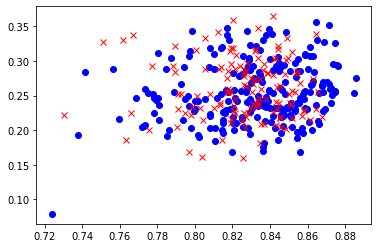

13 0


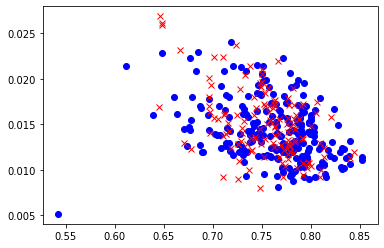

13 1


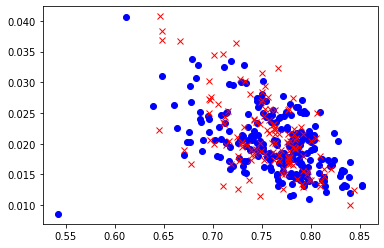

13 2


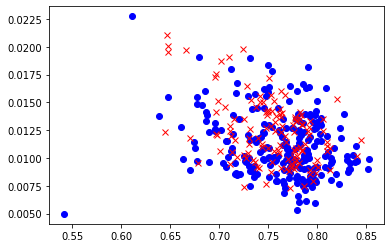

13 3


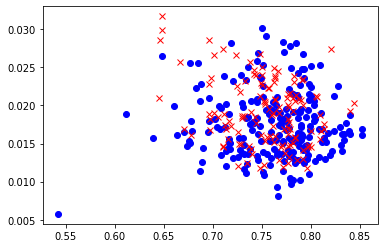

13 4


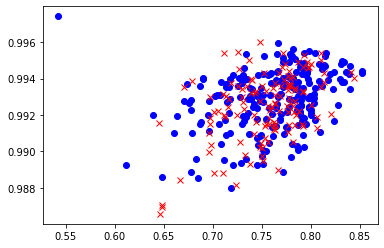

13 5


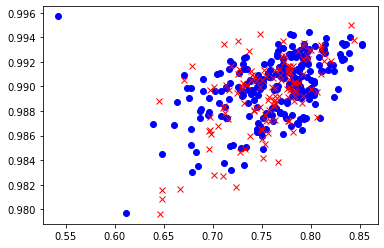

13 6


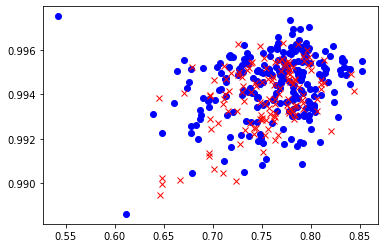

13 7


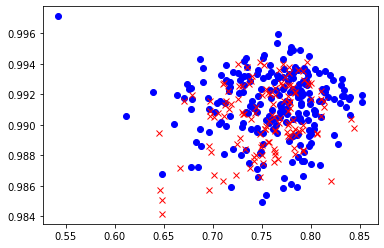

13 8


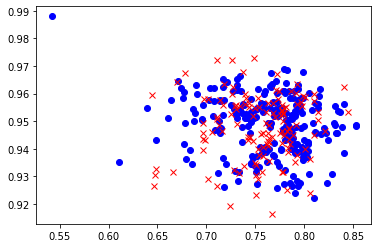

13 9


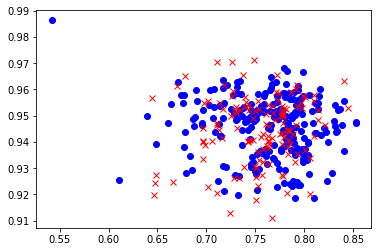

13 10


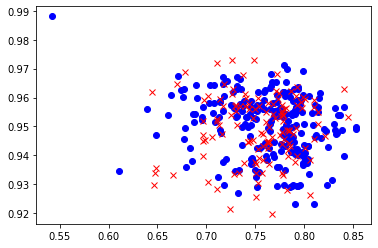

13 11


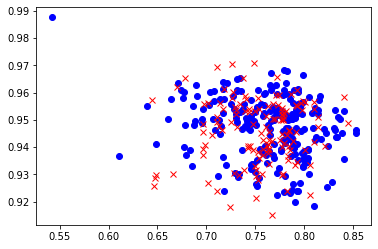

13 12


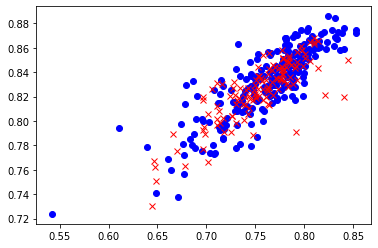

13 14


13 15


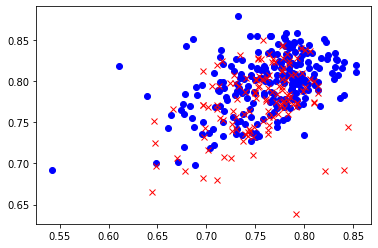

13 16


13 17


13 18


13 19


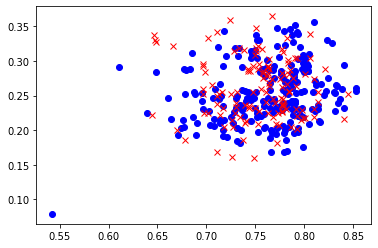

14 0


14 1


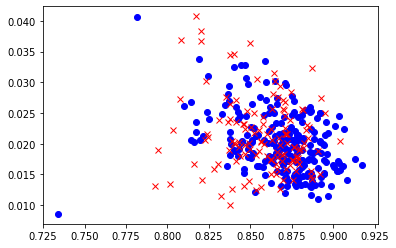

14 2


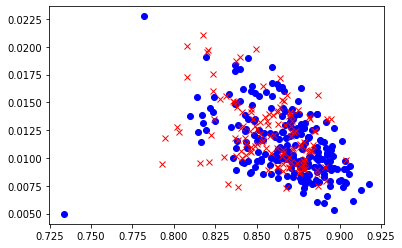

14 3


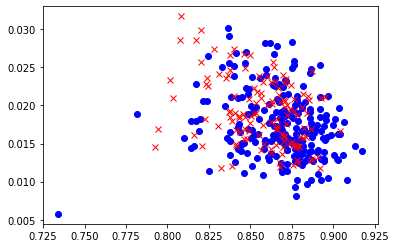

14 4


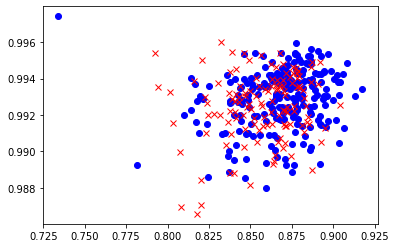

14 5


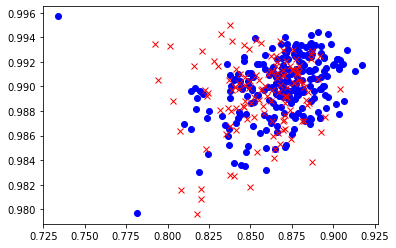

14 6


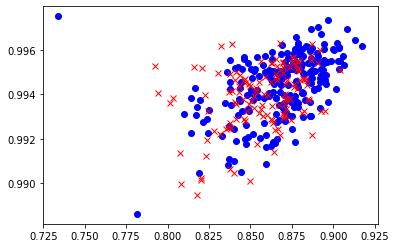

14 7


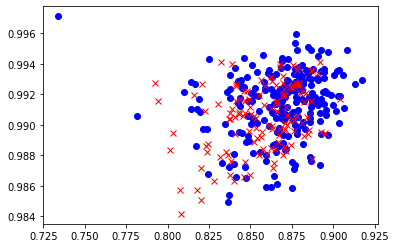

14 8


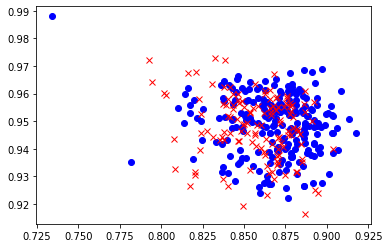

14 9


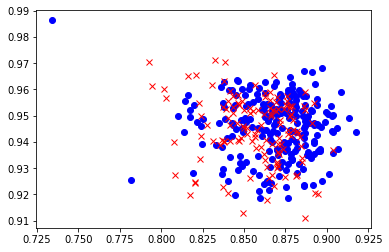

14 10


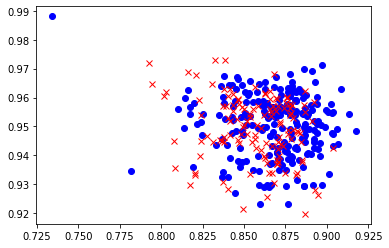

14 11


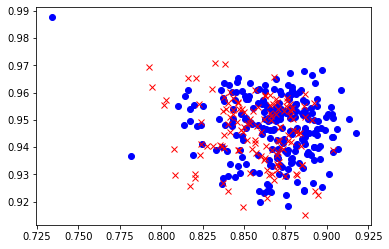

14 12


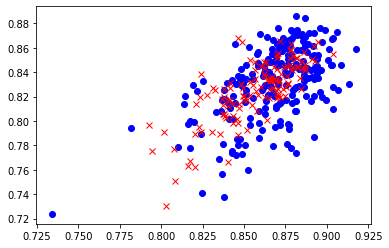

14 13


14 15


14 16


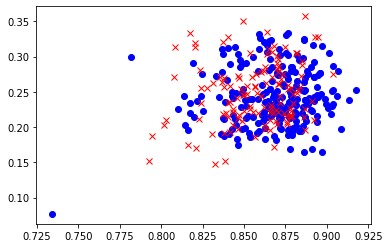

14 17


14 18


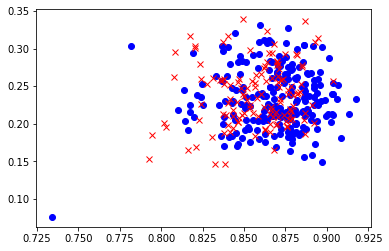

14 19


15 0


15 1


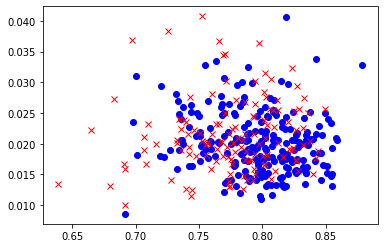

15 2


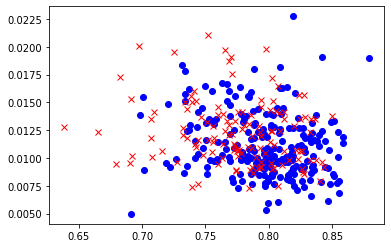

15 3


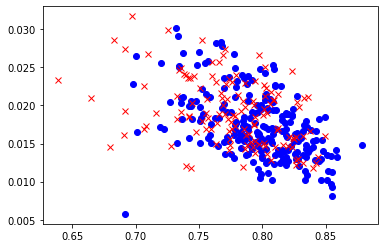

15 4


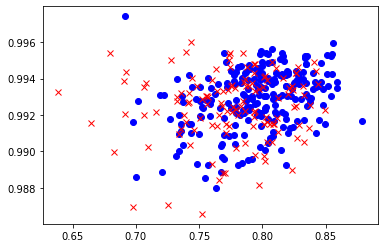

15 5


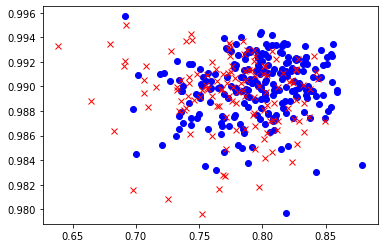

15 6


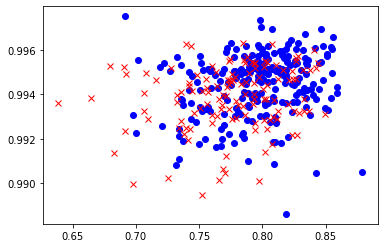

15 7


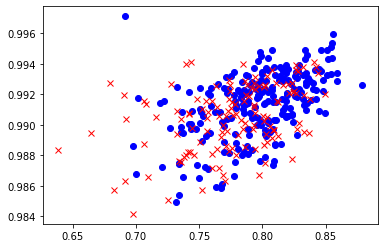

15 8


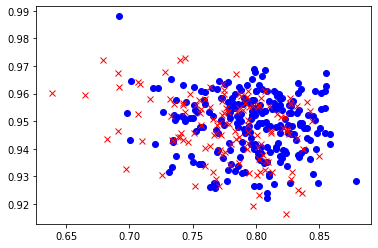

15 9


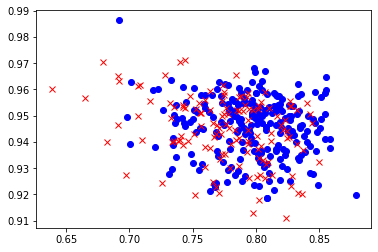

15 10


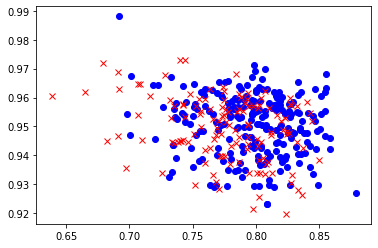

15 11


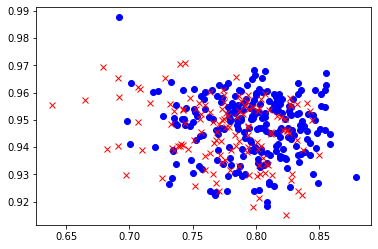

15 12


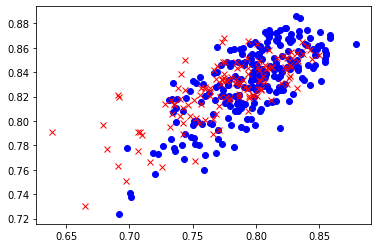

15 13


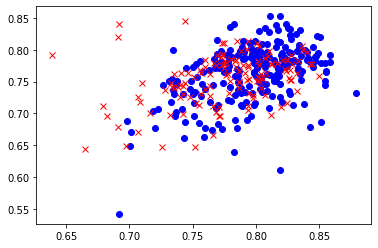

15 14


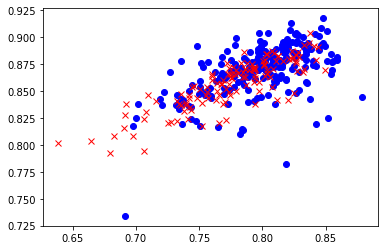

15 16


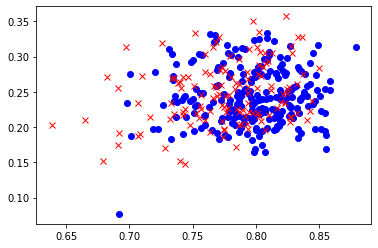

15 17


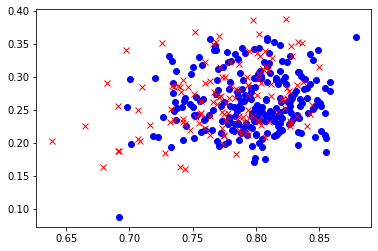

15 18


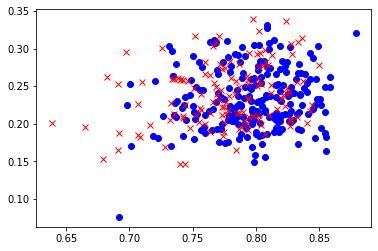

15 19


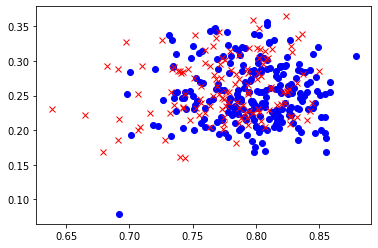

16 0


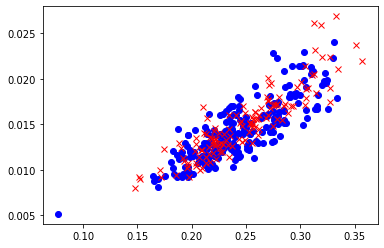

16 1


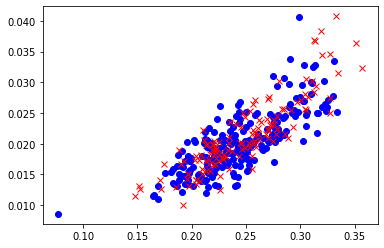

16 2


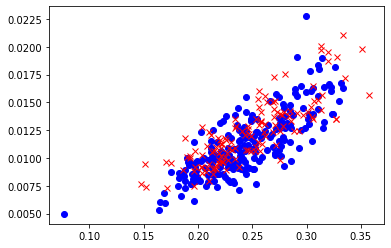

16 3


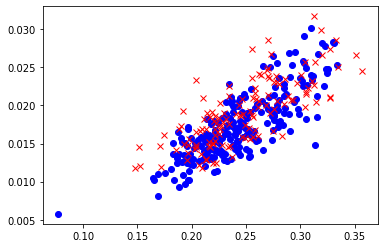

16 4


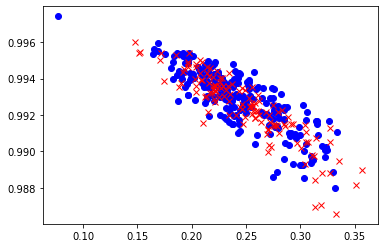

16 5


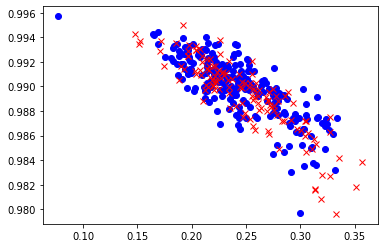

16 6


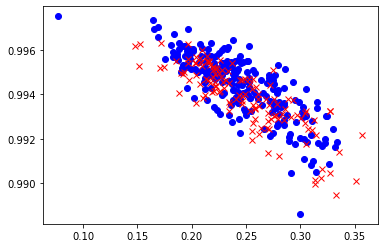

16 7


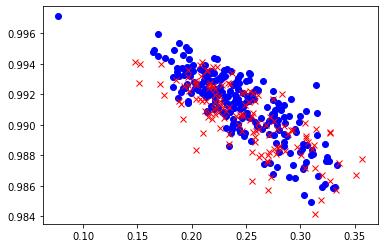

16 8


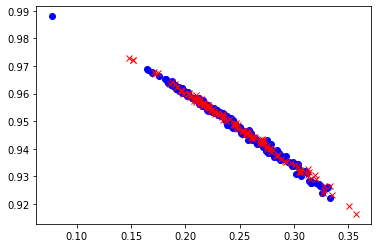

16 9


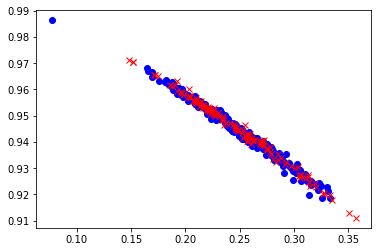

16 10


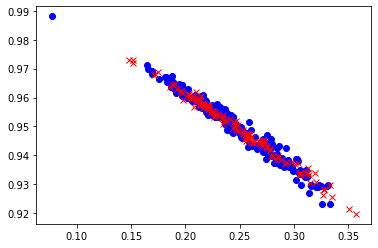

16 11


16 12


16 13


16 14


16 15


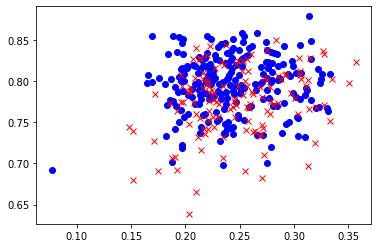

16 17


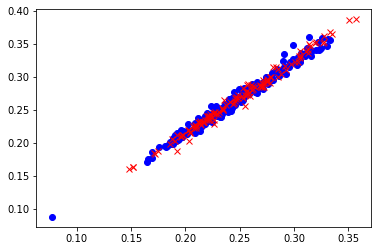

16 18


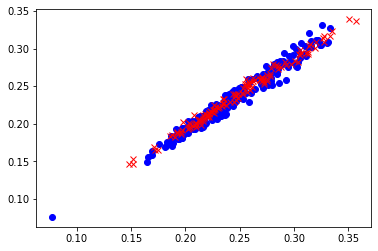

16 19


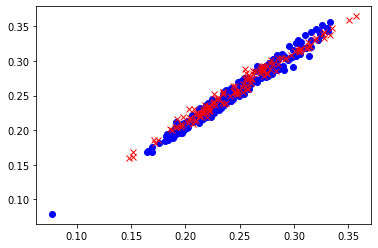

17 0


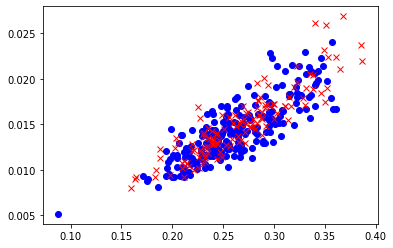

17 1


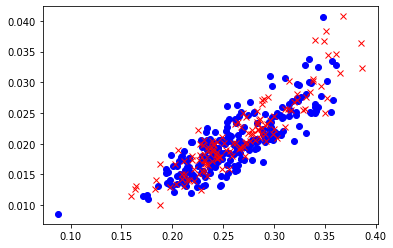

17 2


17 3


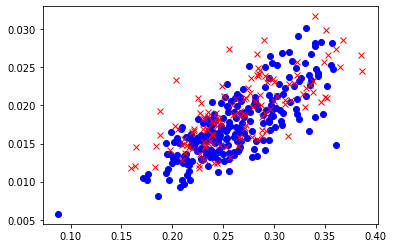

17 4


17 5


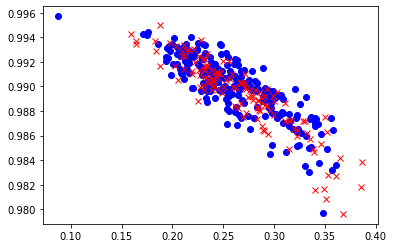

17 6


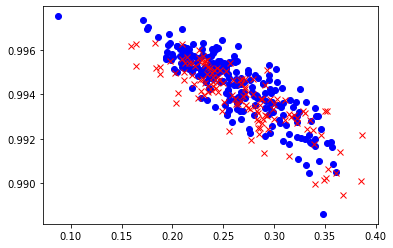

17 7


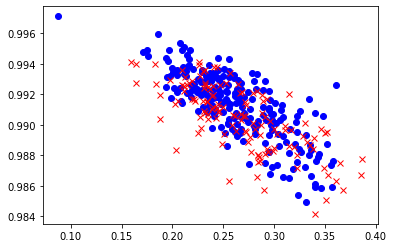

17 8


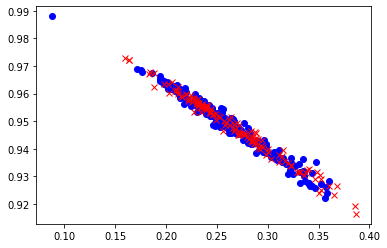

17 9


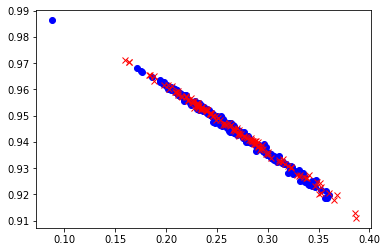

17 10


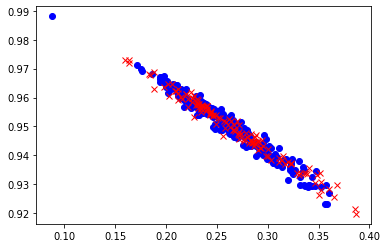

17 11


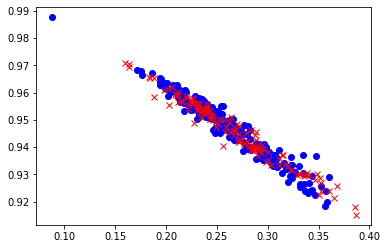

17 12


17 13


17 14


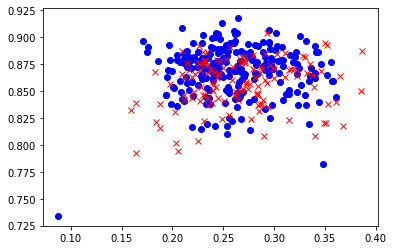

17 15


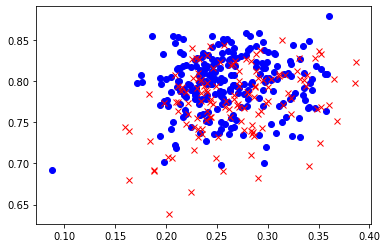

17 16


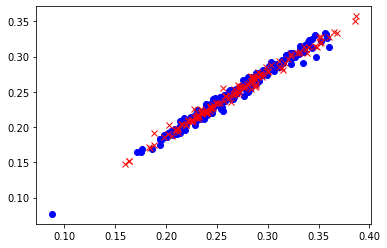

17 18


17 19


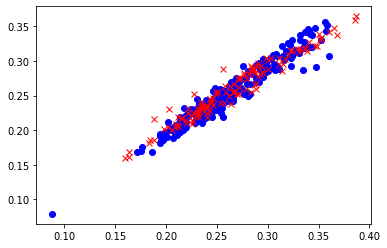

18 0


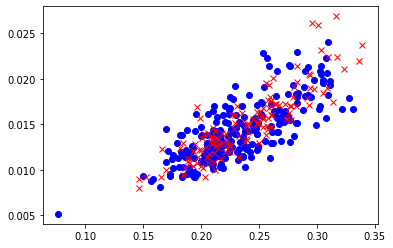

18 1


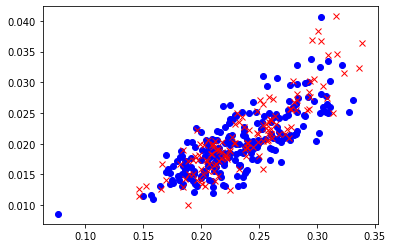

18 2


18 3


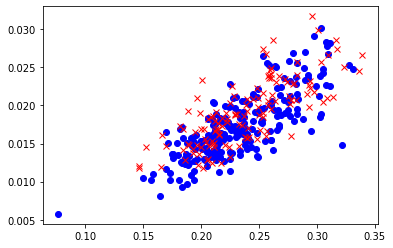

18 4


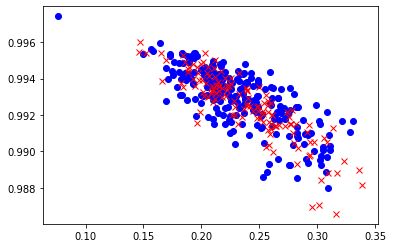

18 5


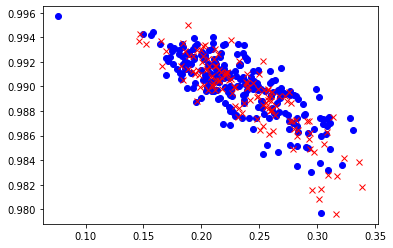

18 6


18 7


18 8


18 9


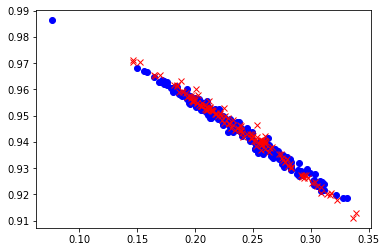

18 10


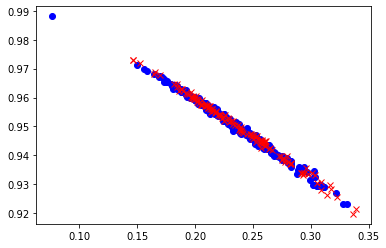

18 11


18 12


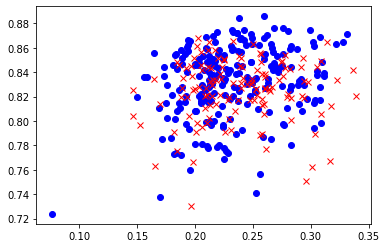

18 13


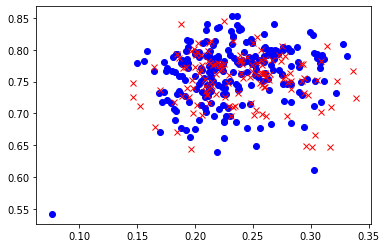

18 14


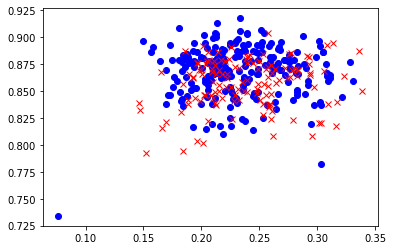

18 15


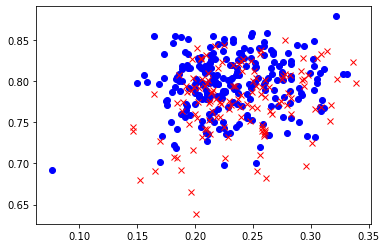

18 16


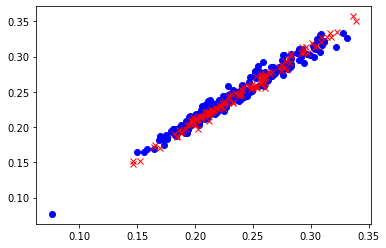

18 17


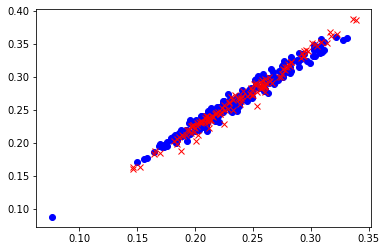

18 19


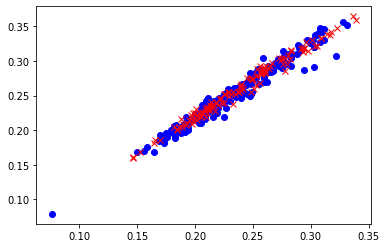

19 0


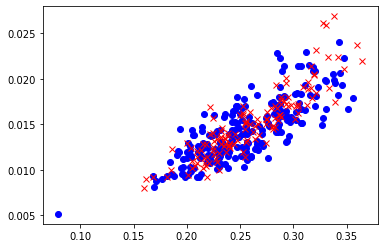

19 1


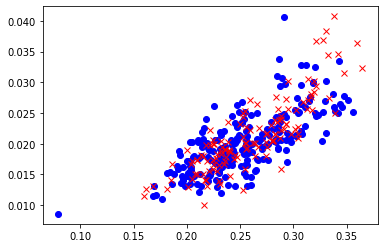

19 2


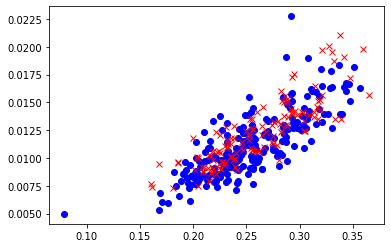

19 3


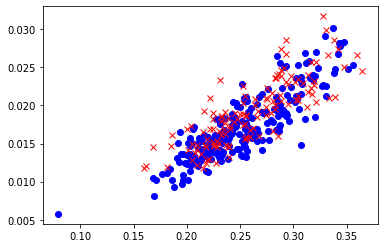

19 4


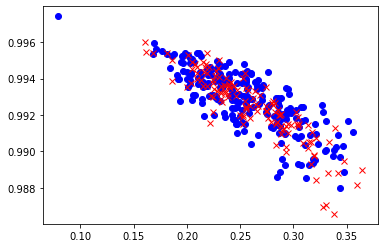

19 5


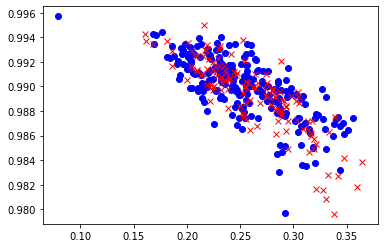

19 6


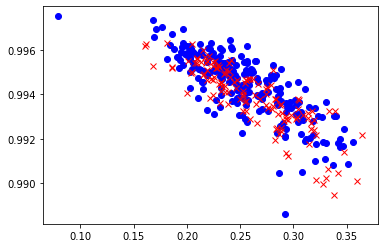

19 7


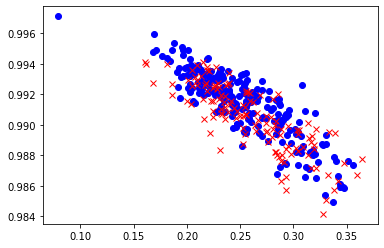

19 8


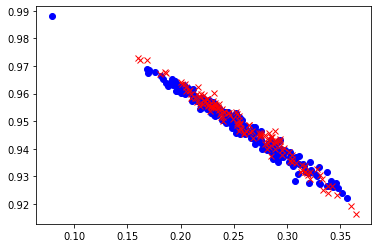

19 9


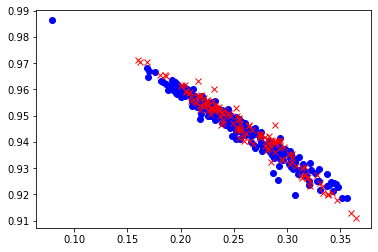

19 10


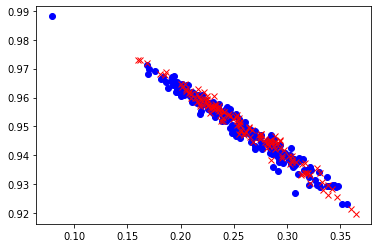

19 11


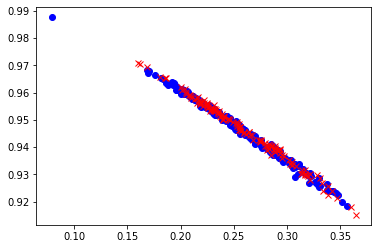

19 12


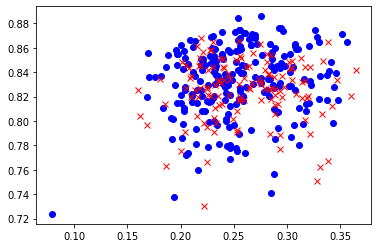

19 13


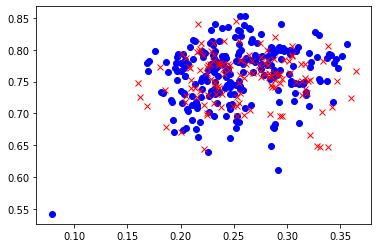

19 14


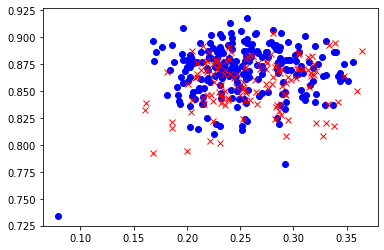

19 15


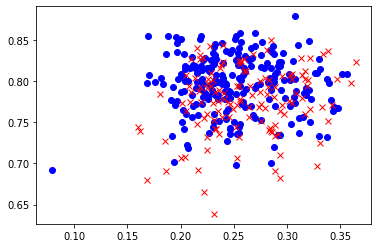

19 16


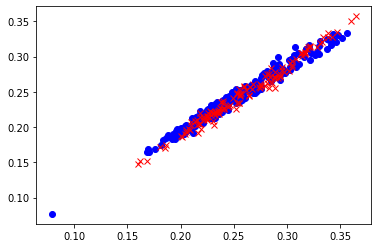

19 17


19 18


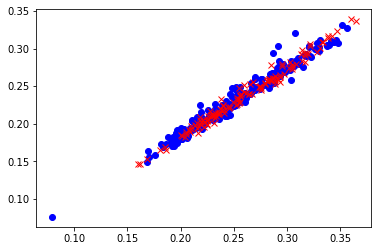

In [13]:
males = []
females = []

for image_path in map(feat('glcm'), CMP_IMAGES):
    gender = 'male'
    if 'female' in image_path:
        females.append(np.loadtxt(image_path))
    else:
        males.append(np.loadtxt(image_path))
males = np.array(males)
females = np.array(females)

for f1 in range(0, len(males[0])):
    for f2 in range(0, len(males[0])):
        if f1 == f2:
            continue
        print(f1, f2)
        plt.plot(males[:, f1], males[:, f2], 'bo')
        plt.plot(females[:, f1], females[:, f2], 'rx')
        plt.show()